In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

## 读取数据

In [2]:
file_path = "./data/估价训练数据.txt"
data = pd.read_csv(file_path, sep='\t', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1,2021-06-28,1,1,1,4.01,1,1,1.0,0,...,NaN,1.0,5.0,2.0,1,4220*1740*1625,201709.0,1,NaN,4.24
1,2,2021-06-25,2,2,2,8.60,1,2,1.0,0,...,NaN,2.0,4.0,3.0,1+2,4630*1775*1480,201609.0,2,NaN,7.38
2,5,2021-06-19,5,5,5,15.56,1,2,3.0,0,...,NaN,NaN,NaN,NaN,NaN,4515*1725*1445,NaN,2,NaN,1.00
3,6,2021-06-29,6,6,6,6.04,1,3,1.0,3,...,2018-08-18,2.0,5.0,2.0,1,4500*1834*1707,201608.0,2,NaN,4.38
4,7,2021-06-30,7,7,7,5.70,4,1,2.0,2,...,2020-09-20,1.0,5.0,2.0,1,4315*1783*1606,201204.0,1,NaN,5.90


## 数据处理

In [3]:
data.shape

(30000, 36)

In [4]:
columns = ["carid", "tradeTime", "brand", "serial", "model", "mileage", "color",
           "cityId", "carCode", "transferCount", "seatings", "registerDate", "licenseDate", "country",
           "maketype", "modelyear", "displacement", "gearbox", "oiltype", "newprice", ] + [f"anonymousFeature{n}" for n in range(1, 16)] + ["price"]
data.columns = columns

In [5]:
data.head()

,carid,tradeTime,brand,serial,model,mileage,color,cityId,carCode,transferCount,...,anonymousFeature7,anonymousFeature8,anonymousFeature9,anonymousFeature10,anonymousFeature11,anonymousFeature12,anonymousFeature13,anonymousFeature14,anonymousFeature15,price
0,1,2021-06-28,1,1,1,4.01,1,1,1.0,0,...,NaN,1.0,5.0,2.0,1,4220*1740*1625,201709.0,1,NaN,4.24
1,2,2021-06-25,2,2,2,8.60,1,2,1.0,0,...,NaN,2.0,4.0,3.0,1+2,4630*1775*1480,201609.0,2,NaN,7.38
2,5,2021-06-19,5,5,5,15.56,1,2,3.0,0,...,NaN,NaN,NaN,NaN,NaN,4515*1725*1445,NaN,2,NaN,1.00
3,6,2021-06-29,6,6,6,6.04,1,3,1.0,3,...,2018-08-18,2.0,5.0,2.0,1,4500*1834*1707,201608.0,2,NaN,4.38
4,7,2021-06-30,7,7,7,5.70,4,1,2.0,2,...,2020-09-20,1.0,5.0,2.0,1,4315*1783*1606,201204.0,1,NaN,5.90


In [6]:
data.info() # 看看有哪些

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   carid               30000 non-null  int64  
 1   tradeTime           30000 non-null  object 
 2   brand               30000 non-null  int64  
 3   serial              30000 non-null  int64  
 4   model               30000 non-null  int64  
 5   mileage             30000 non-null  float64
 6   color               30000 non-null  int64  
 7   cityId              30000 non-null  int64  
 8   carCode             29991 non-null  float64
 9   transferCount       30000 non-null  int64  
 10  seatings            30000 non-null  int64  
 11  registerDate        30000 non-null  object 
 12  licenseDate         30000 non-null  object 
 13  country             26243 non-null  float64
 14  maketype            26359 non-null  float64
 15  modelyear           29688 non-null  float64
 16  disp

只取缺失值较少或者没有的查看异常值

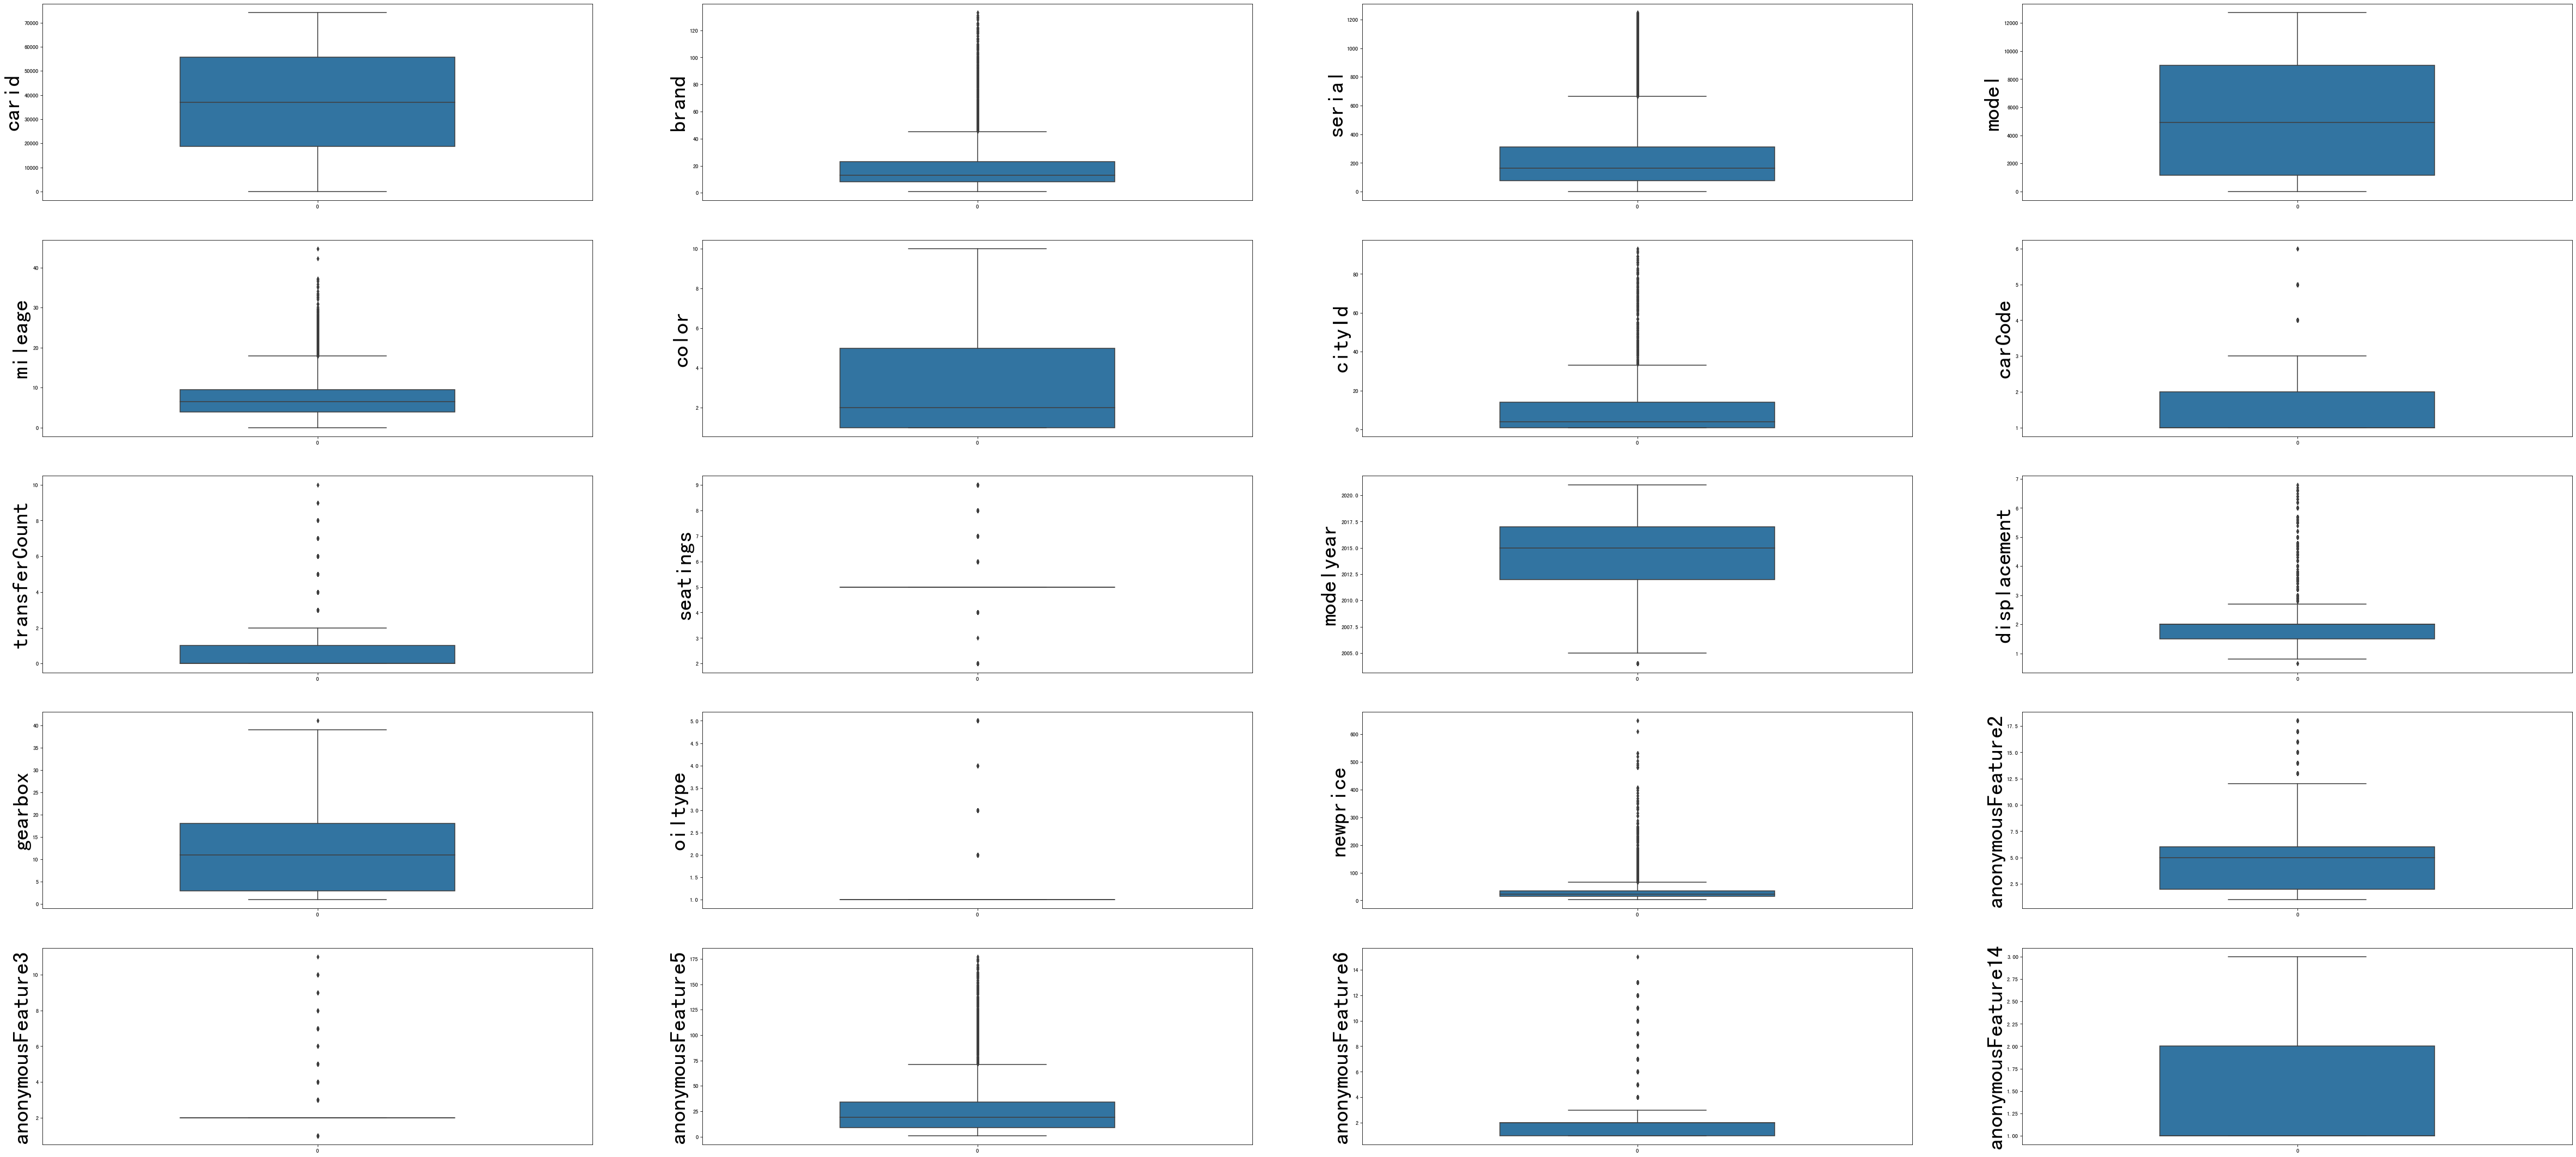

In [7]:
# 缺失值较少或者没有的列
col = [i for i in data.columns if data[i].isnull().sum() < len(data) * 0.05]
# 去掉几个不是数值的列
col.remove("registerDate")
col.remove("licenseDate")
col.remove("tradeTime")
col.remove("anonymousFeature11")
col.remove("anonymousFeature12")
#通过画箱型图来查看异常值
fig = plt.figure(figsize=(80,60),dpi=75)
for i in range(len(col[:-1])):
    plt.subplot(8,4,i+1)
    sns.boxplot(data=data[col[i]],orient= 'v',width=0.5)
    plt.ylabel(col[i],fontsize = 40)
plt.show()

In [8]:
data["price"].describe()

count     30000.000000
mean         18.062224
std         629.444049
min           0.050000
25%           6.100000
50%          10.479900
75%          18.000000
max      109000.000000
Name: price, dtype: float64

从结果可以看出平均值为18，但最大值已经100000了，因此要做异常值处理

In [9]:
# 将处理异常值封装成函数
def outliers_solve(series):
    a = series.quantile(0.75)
    b = series.quantile(0.25)
    c = series
    c[(c>=(a-b)*1.5+a)|(c<=b-(a-b)*1.5)]=np.nan
    c.fillna(c.median(),inplace=True)
    return c

data["price"] = outliers_solve(data["price"])

这样价异常值处理就算完成了

下面看一些分布

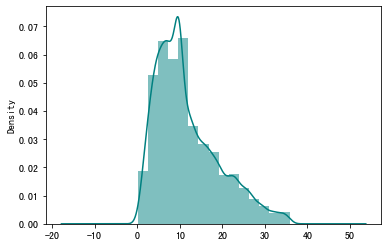

In [10]:
# 价格的分布
ax = data["price"].hist(bins=15, density=True, stacked=True, color="teal", alpha=0.5)
data["price"].plot(kind="density", color="teal")
plt.show()

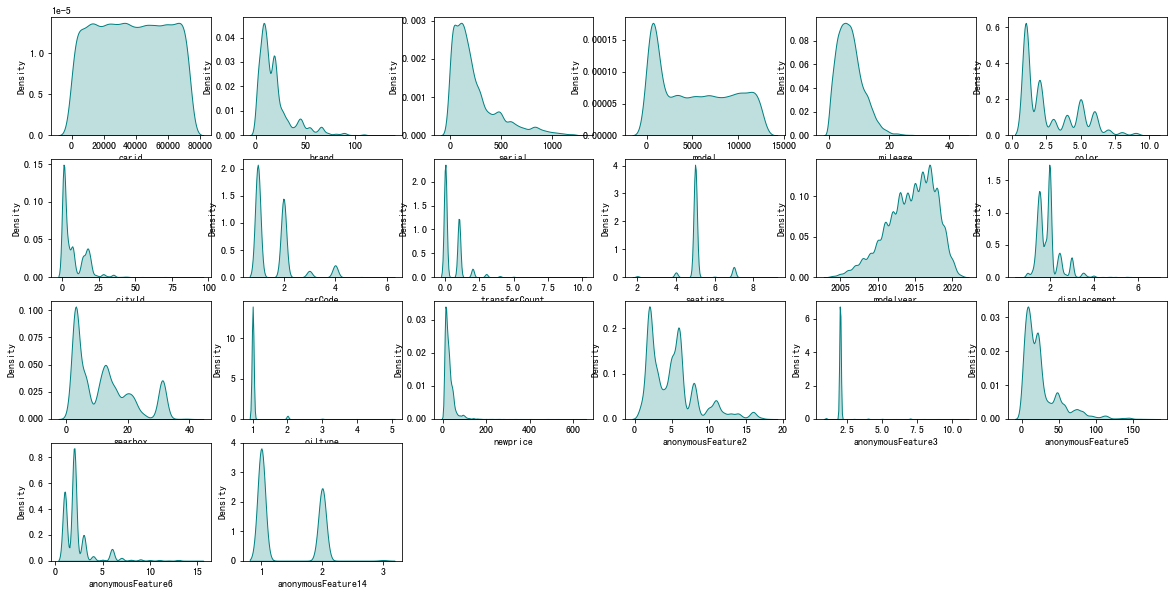

In [11]:
# 其它特征的分布
plt.figure(figsize=(20,10))
for i in range(len(col[:-1])):
    plt.subplot(4, 6, i+1)
    sns.kdeplot(data[col[i]], shade=True, color="teal")
plt.show()

In [12]:
np.round(data.isnull().sum() / data.shape[0], 4) # 查看缺失值的比例

carid                 0.0000
tradeTime             0.0000
brand                 0.0000
serial                0.0000
model                 0.0000
mileage               0.0000
color                 0.0000
cityId                0.0000
carCode               0.0003
transferCount         0.0000
seatings              0.0000
registerDate          0.0000
licenseDate           0.0000
country               0.1252
maketype              0.1214
modelyear             0.0104
displacement          0.0000
gearbox               0.0000
oiltype               0.0000
newprice              0.0000
anonymousFeature1     0.0527
anonymousFeature2     0.0000
anonymousFeature3     0.0000
anonymousFeature4     0.4036
anonymousFeature5     0.0000
anonymousFeature6     0.0000
anonymousFeature7     0.6015
anonymousFeature8     0.1258
anonymousFeature9     0.1248
anonymousFeature10    0.2080
anonymousFeature11    0.0154
anonymousFeature12    0.0000
anonymousFeature13    0.0540
anonymousFeature14    0.0000
anonymousFeatu

发现有三列的缺失值太多，因此去除这三列。anonymousFeature11这一列意义不明先去除。

In [13]:
data = data.drop(columns=["anonymousFeature4", "anonymousFeature7", "anonymousFeature15", "anonymousFeature11"])

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   carid               30000 non-null  int64  
 1   tradeTime           30000 non-null  object 
 2   brand               30000 non-null  int64  
 3   serial              30000 non-null  int64  
 4   model               30000 non-null  int64  
 5   mileage             30000 non-null  float64
 6   color               30000 non-null  int64  
 7   cityId              30000 non-null  int64  
 8   carCode             29991 non-null  float64
 9   transferCount       30000 non-null  int64  
 10  seatings            30000 non-null  int64  
 11  registerDate        30000 non-null  object 
 12  licenseDate         30000 non-null  object 
 13  country             26243 non-null  float64
 14  maketype            26359 non-null  float64
 15  modelyear           29688 non-null  float64
 16  disp

选择用众数填充空值

In [15]:
def fill_null(series):
    m = series.mode()[0]
    series.fillna(m, inplace=True)
    return series
l = [i for i in data.columns if data[i].isnull().sum() > 0]
for i in l:
    data[i] = fill_null(data[i])
data.isnull().sum()


carid                 0
tradeTime             0
brand                 0
serial                0
model                 0
mileage               0
color                 0
cityId                0
carCode               0
transferCount         0
seatings              0
registerDate          0
licenseDate           0
country               0
maketype              0
modelyear             0
displacement          0
gearbox               0
oiltype               0
newprice              0
anonymousFeature1     0
anonymousFeature2     0
anonymousFeature3     0
anonymousFeature5     0
anonymousFeature6     0
anonymousFeature8     0
anonymousFeature9     0
anonymousFeature10    0
anonymousFeature12    0
anonymousFeature13    0
anonymousFeature14    0
price                 0
dtype: int64

通过自定义函数来展示以不同特征分组的平均价格

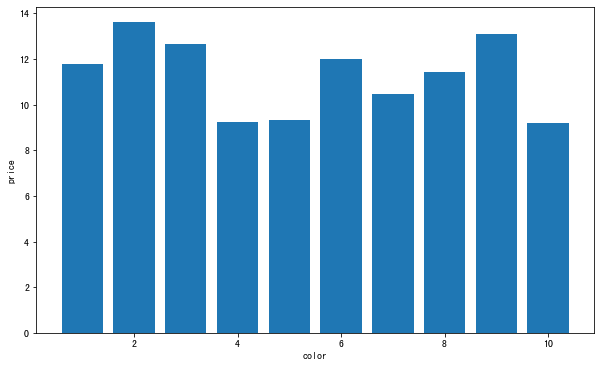

In [16]:
def show_mean_graph(data, colname):
    temp = data.groupby(colname)["price"].mean()
    plt.figure(figsize=(10, 6))
    plt.bar(temp.index, temp)
    plt.xlabel(colname)
    plt.ylabel("price")
    plt.show()

# 颜色
show_mean_graph(data, "color")

发现颜色的影响并不是很大

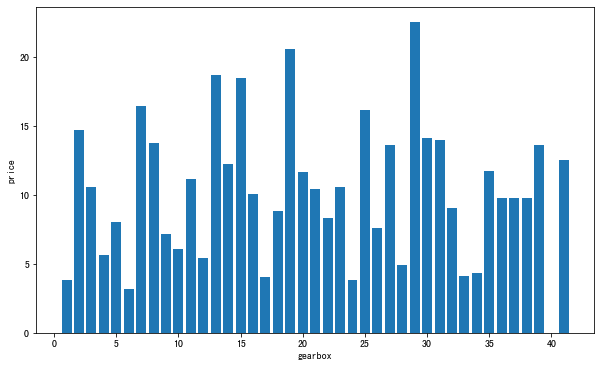

In [17]:
# 变速箱
show_mean_graph(data, "gearbox")

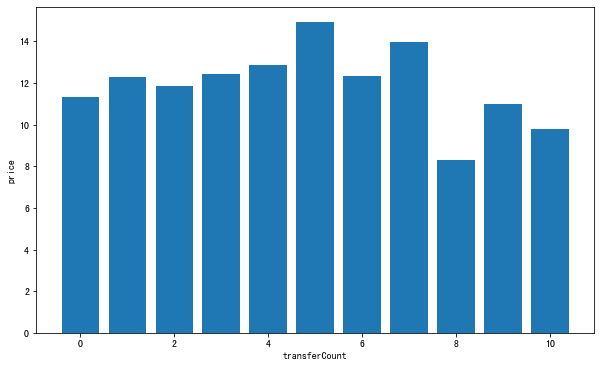

In [18]:
# 过户次数
show_mean_graph(data, "transferCount")


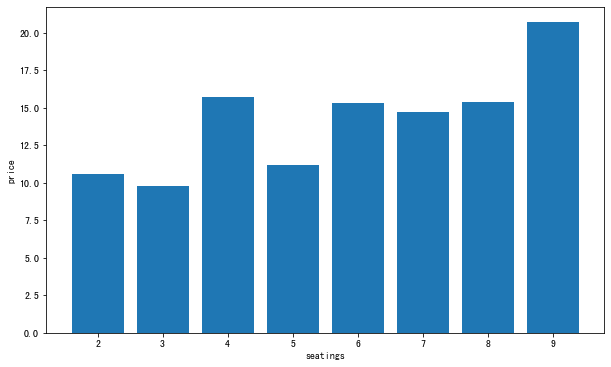

In [19]:
# 载客人数
show_mean_graph(data, "seatings")

分析相关性

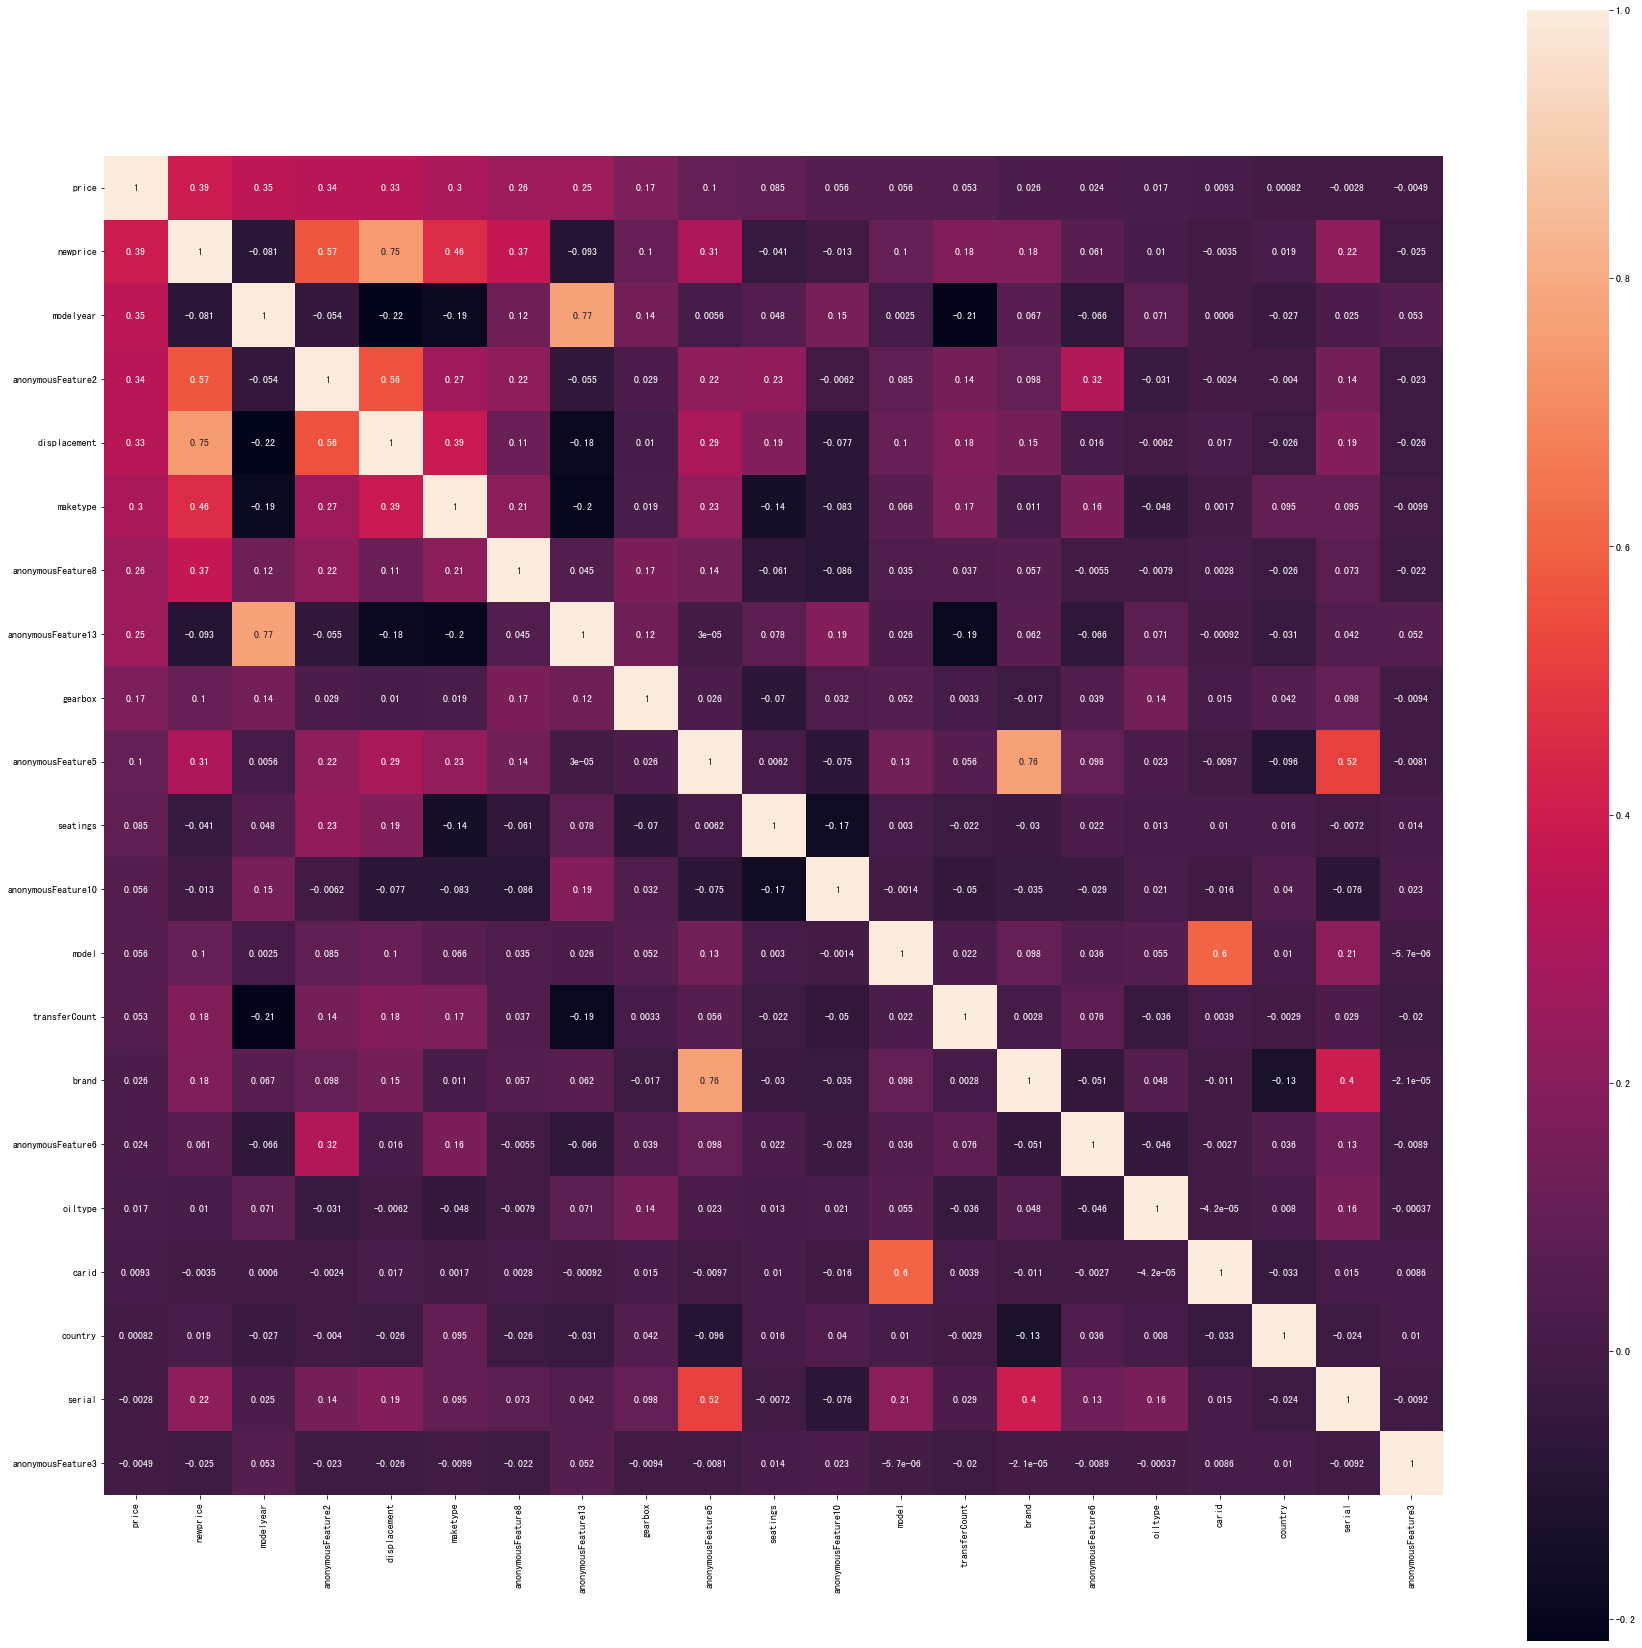

In [20]:
corr = data.corr()
col2 =  corr.nlargest(len(col),'price')['price'].index
hm = plt.subplots(figsize = (30,30))
hm = sns.heatmap(data[col2].corr(), annot=True, square=True)
plt.show()

由这个图可以看出来'newprice', 'modelyear', 'anonymousFeature2', 'displacement',
       'maketype', 'anonymousFeature8', 'anonymousFeature13', 'gearbox',
       'anonymousFeature5' 这些特征与价格关系比较大

In [21]:
data.columns

Index(['carid', 'tradeTime', 'brand', 'serial', 'model', 'mileage', 'color',
       'cityId', 'carCode', 'transferCount', 'seatings', 'registerDate',
       'licenseDate', 'country', 'maketype', 'modelyear', 'displacement',
       'gearbox', 'oiltype', 'newprice', 'anonymousFeature1',
       'anonymousFeature2', 'anonymousFeature3', 'anonymousFeature5',
       'anonymousFeature6', 'anonymousFeature8', 'anonymousFeature9',
       'anonymousFeature10', 'anonymousFeature12', 'anonymousFeature13',
       'anonymousFeature14', 'price'],
      dtype='object')

In [22]:
X = data[col[:-1]]
y = data["price"]
X

,carid,brand,serial,model,mileage,color,cityId,carCode,transferCount,seatings,modelyear,displacement,gearbox,oiltype,newprice,anonymousFeature2,anonymousFeature3,anonymousFeature5,anonymousFeature6,anonymousFeature14
0,1,1,1,1,4.01,1,1,1.0,0,5,2017.0,1.5,1.0,1,6.88,1,1,1,1,1
1,2,2,2,2,8.60,1,2,1.0,0,5,2017.0,1.2,2.0,1,11.98,2,2,2,2,2
2,5,5,5,5,15.56,1,2,3.0,0,5,2008.0,1.6,4.0,1,12.78,2,2,5,2,2
3,6,6,6,6,6.04,1,3,1.0,3,5,2016.0,1.3,2.0,1,9.49,5,2,6,1,2
4,7,7,7,7,5.70,4,1,2.0,2,5,2012.0,2.0,5.0,1,18.08,5,2,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,18531,34,588,4169,10.38,5,35,3.0,0,5,2006.0,1.8,6.0,1,11.86,14,2,36,6,1
29996,4294,12,92,1797,11.69,2,1,2.0,2,5,2012.0,2.0,22.0,1,20.28,6,2,16,2,2
29997,20584,7,113,501,9.87,6,1,2.0,0,5,2009.0,1.6,4.0,1,14.58,2,2,7,2,2
29998,11490,45,131,3024,9.57,1,1,1.0,1,5,2015.0,2.5,25.0,2,35.40,8,2,47,2,1


## 模型训练预测

In [95]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score
# import lightgbm as lgb

In [96]:
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
kfold = KFold(n_splits=5, shuffle=True, random_state=1111)
# model = SVR(kernel="rbf", C=25, gamma=0.1)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2, max_depth=12, random_state=0, loss="huber")
# model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
for fold, (trn_id, val_id) in enumerate(kfold.split(X_train, y_train)):
    print("fold", fold + 1)
    x_train, y_train, x_val, y_val = X[trn_id], y[trn_id], X[val_id], y[val_id]
    model.fit(x_train, y_train)
    print("train score:", model.score(x_val, y_val))
    

fold 1
train score: 0.8798984014876017
fold 2
train score: 0.887396821157292
fold 3
train score: 0.8770342606966621
fold 4
train score: 0.8723794876323392
fold 5
train score: 0.8731994232993605


In [87]:
model.score(X_test, y_test)

0.9456974447617177

In [88]:
def Accuracy(y_true, y_pred):
    m = y_true.shape[0]
    Ape = np.abs(y_pred-y_true)/y_true
    Mape = np.sum(Ape)/m
    Accuracy5 = len(np.where(Ape<=0.05)[0]) / m
    return 0.2*(1-Mape)+0.8*Accuracy5


In [89]:
y_pred = model.predict(X_test)

In [90]:
Accuracy(y_test, y_pred) 

0.7626176974006519

In [91]:
test_data = pd.read_csv("./data/估价验证数据.txt", sep="\t", encoding="utf-8")
test_data.columns = columns[:-1]
testX = test_data[col[:-1]]
testX["modelyear"] = testX["modelyear"].fillna(testX["modelyear"].mode()[0])

In [79]:
res = pd.DataFrame({"id": testX["carid"], "price": model.predict(StandardScaler().fit_transform(testX[col[:-1]]))})


## 保存预测结果

In [81]:
# res.sort_values("id", inplace=True)
res.to_csv("./data/估价模型结果.txt", sep="\t", index=False)